In [1]:
# _*_coding:utf-8_*_

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import pandas as pd
import numpy as np
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 12, 4

% matplotlib inline

/home/liu/py3venv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train_data = '/home/liu/mysoft/pycharm/project/quantist/quantist/example/xgboost/train_modified.csv'
test_data = '/home/liu/mysoft/pycharm/project/quantist/quantist/example/xgboost/test_modified.csv'

train = pd.read_csv(train_data)
test = pd.read_csv(test_data)

train.shape, test.shape

((87020, 51), (37717, 50))

In [3]:
target = 'Disbursed'
IDcol = 'ID'

train['Disbursed'].value_counts()

0.0    85747
1.0     1273
Name: Disbursed, dtype: int64

In [4]:
print(train.head())

   Disbursed  Existing_EMI           ID  Loan_Amount_Applied  \
0        0.0           0.0  ID000002C20             300000.0   
1        0.0           0.0  ID000004E40             200000.0   
2        0.0           0.0  ID000007H20             600000.0   
3        0.0           0.0  ID000008I30            1000000.0   
4        0.0       25000.0  ID000009J40             500000.0   

   Loan_Tenure_Applied  Monthly_Income  Var4  Var5  Age  \
0                  5.0           20000     1     0   37   
1                  2.0           35000     3    13   30   
2                  4.0           22500     1     0   34   
3                  5.0           35000     3    10   28   
4                  2.0          100000     3    17   31   

   EMI_Loan_Submitted_Missing    ...     Var2_2  Var2_3  Var2_4  Var2_5  \
0                           1    ...        0.0     0.0     0.0     0.0   
1                           0    ...        0.0     0.0     0.0     0.0   
2                           1    ..

In [5]:
print(train.describe())

          Disbursed  Existing_EMI  Loan_Amount_Applied  Loan_Tenure_Applied  \
count  87020.000000  8.702000e+04         8.702000e+04         87020.000000   
mean       0.014629  3.693212e+03         2.301444e+05             2.131292   
std        0.120062  3.979411e+04         3.540818e+05             2.013375   
min        0.000000  0.000000e+00         0.000000e+00             0.000000   
25%        0.000000  0.000000e+00         0.000000e+00             0.000000   
50%        0.000000  0.000000e+00         1.000000e+05             2.000000   
75%        0.000000  3.500000e+03         3.000000e+05             4.000000   
max        1.000000  1.000000e+07         1.000000e+07            10.000000   

       Monthly_Income          Var4          Var5           Age  \
count    8.702000e+04  87020.000000  87020.000000  87020.000000   
mean     5.884997e+04      2.949805      4.961503     30.904171   
std      2.177511e+06      1.697720      5.670385      7.147194   
min      0.000000e+0

In [6]:
# 建模与交叉验证
# 写一个大的函数完成以下的功能
# 
# 数据建模
# 求训练准确率
# 求训练集AUC
# 根据xgboost交叉验证更新n_estimators
# 画出特征的重要度

def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True,cv_folds=5,early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values,label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
             early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    # model
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
    
    # predic for test
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    print('accuary %.4g'%metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print('Score_train %f'%metrics.roc_auc_score(dtrain['Disbursed'],dtrain_predprob))
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
        

accuary 0.9854
Score_train 0.830662


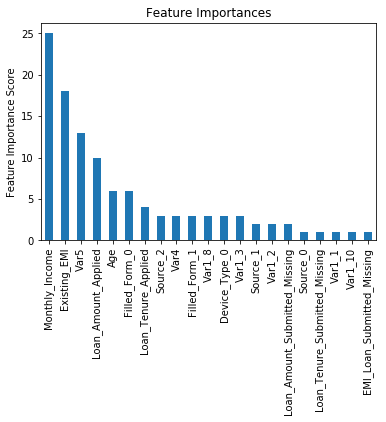

In [7]:
# 第1步- 对于高的学习率找到最合适的estimators个数
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)
modelfit(xgb1, train, test, predictors)

# 准确率 : 0.9854
# AUC 得分 (训练集): 0.817509

In [19]:
#对subsample 和 max_features 用grid search查找最好的参数
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

NameError: name 'gsearch1' is not defined

In [20]:
# 对于max_depth和min_child_weight查找最好的参数
param_test2 = {
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

KeyboardInterrupt: 